In [1]:
import gzip
import numpy as np
import pandas as pd
from time import time
import random

# from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
# from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
# from keras.callbacks import TensorBoard

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import gc

In [4]:
# retrieve data set

from requests import get

def download_file(url, file_name):
    with open(file_name, "wb") as file:
        response = get(url)
        file.write(response.content)
        
download_file('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', 'train-images-idx3-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 'train-labels-idx1-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', 't10k-images-idx3-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

In [5]:
def read_mnist(images_path: str, labels_path: str):
    with gzip.open(labels_path, 'rb') as labelsFile:
        labels = np.frombuffer(labelsFile.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path,'rb') as imagesFile:
        length = len(labels)
        # Load flat 28x28 px images (784 px), and convert them to 28x28 px
        features = np.frombuffer(imagesFile.read(), dtype=np.uint8, offset=16) \
                        .reshape(length, 784) \
                        .reshape(length, 28, 28)
#                         .reshape(length, 28, 28, 1)
        
    return features, labels

In [6]:
train = {}
test = {}

train['features'], train['labels'] = read_mnist('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')
test['features'], test['labels'] = read_mnist('t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

In [7]:
train['features'].shape

(60000, 28, 28)

In [8]:
# Pad images with 0s to 32x32
train['features']      = np.pad(train['features'], ((0,0),(2,2),(2,2)), 'constant')
test['features']       = np.pad(test['features'], ((0,0),(2,2),(2,2)), 'constant')
    
print("Updated Image Shape: {}".format(train['features'].shape))

Updated Image Shape: (60000, 32, 32)


In [9]:
train_init= train['features']
train_labels= to_categorical(train['labels'])
test_init= test['features']
test_labels= to_categorical(test['labels'])

In [10]:
# Black and white model - LeNet

model_LeNet_BW = keras.Sequential([
    layers.Reshape(input_shape=(32,32), target_shape=(32, 32, 1)),
    layers.Conv2D(filters=6,
                  kernel_size=(5, 5),
                  strides=2,
                  padding='same',
                  activation='sigmoid'),
    layers.AveragePooling2D(pool_size=(2,2),
                            strides=2,
                            padding='valid'),
    layers.Conv2D(filters=16,
                  kernel_size=(5, 5),
                  activation='sigmoid',
                  padding='valid'),
    layers.AveragePooling2D(pool_size=(2,2),
                            strides=2,
                            padding='valid'),
    layers.Flatten(),
    layers.Dense(120, activation='sigmoid'),
    layers.Dense(84, activation='sigmoid'),
    layers.Dense(10, activation='sigmoid')
])

model_LeNet_BW._name="LeNet_BlackWhite"

model_LeNet_BW.summary()

model_LeNet_BW.compile(loss=keras.losses.categorical_crossentropy,
              optimizer="Adam", metrics=['accuracy'])

Model: "LeNet_BlackWhite"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 8, 8, 6)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 16)          2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 2, 2, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 120)          

In [11]:
EPOCHS = 10
BATCH_SIZE = 64

model_LeNet_BW_fit= model_LeNet_BW.fit(train_init,
                                       train_labels,
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       validation_split=0.15)

Epoch 1/10
797/797 [==============================] - 50s 13ms/step - loss: 2.0395 - accuracy: 0.2622 - val_loss: 0.5360 - val_accuracy: 0.8476
Epoch 2/10
797/797 [==============================] - 9s 11ms/step - loss: 0.4845 - accuracy: 0.8508 - val_loss: 0.2892 - val_accuracy: 0.9094
Epoch 3/10
797/797 [==============================] - 8s 10ms/step - loss: 0.2960 - accuracy: 0.9068 - val_loss: 0.2134 - val_accuracy: 0.9350
Epoch 4/10
797/797 [==============================] - 8s 10ms/step - loss: 0.2341 - accuracy: 0.9264 - val_loss: 0.1761 - val_accuracy: 0.9450
Epoch 5/10
797/797 [==============================] - 9s 11ms/step - loss: 0.1902 - accuracy: 0.9407 - val_loss: 0.1618 - val_accuracy: 0.9504
Epoch 6/10
797/797 [==============================] - 9s 11ms/step - loss: 0.1717 - accuracy: 0.9449 - val_loss: 0.1417 - val_accuracy: 0.9580
Epoch 7/10
797/797 [==============================] - 9s 12ms/step - loss: 0.1510 - accuracy: 0.9520 - val_loss: 0.1371 - val_accuracy: 0.957

In [12]:
# get test results from LeNet BW test set

LeNet_BW_results=model_LeNet_BW(test_init)

# cross tab of actuals and predictions
pred_results = pd.DataFrame({'P0': LeNet_BW_results[:, 0], 'P1': LeNet_BW_results[:, 1],
                              'P2': LeNet_BW_results[:, 2], 'P3': LeNet_BW_results[:, 3],
                              'P4': LeNet_BW_results[:, 4], 'P5': LeNet_BW_results[:, 5],
                              'P6': LeNet_BW_results[:, 6], 'P7': LeNet_BW_results[:, 7],
                              'P8': LeNet_BW_results[:, 8], 'P9': LeNet_BW_results[:, 9]
                       })

preds = np.argmax(pred_results.values,axis=1)
pred_results['predictions'] = preds
pred_results['actuals'] = test['labels']
ct = pd.crosstab(index=pred_results['actuals'], columns=pred_results['predictions'])

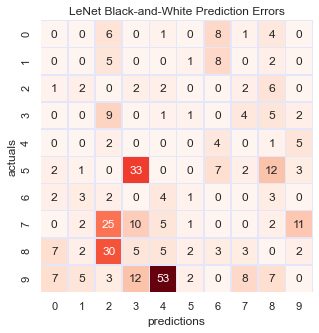

In [13]:
# heatmap of results - LeNet Black-White

# zero out diagonal for this heatmap as we are only interested in off diagonal
np.fill_diagonal(ct.values,0)

sns.set(rc = {'figure.figsize':(5,5)})

sns.heatmap(ct,
            cmap='Reds',
            annot=True,
            fmt=".0f",
            linewidths=0.5,
            linecolor='lavender',
#             annot_kws={'size':8},
            cbar=False,
            square=True).set(title="LeNet Black-and-White Prediction Errors")

plt.savefig('LeNet_BW_PredErrors.png')

plt.show()

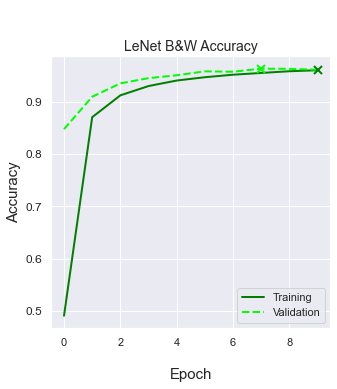

In [24]:
# note: if loss curve starts to reverse direction we could be overfitting model

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)
# get max values for annotation
ind_xta = np.argmax(model_LeNet_BW_fit.history['accuracy'])
ind_xva = np.argmax(model_LeNet_BW_fit.history['val_accuracy'])
plt.title('\n\nLeNet B&W Accuracy',size=14)


ax1.set_xlabel('\nEpoch', size=15)
ax1.set_ylabel('Accuracy',size=15)
    
ax1.plot(model_LeNet_BW_fit.history['accuracy'], color='green', linestyle='-',linewidth=2,label='Training')
plt.plot(model_LeNet_BW_fit.history['val_accuracy'], color='lime', linestyle='--',linewidth=2,label='Validation')

plt.plot(ind_xta, model_LeNet_BW_fit.history['accuracy'][ind_xta], 'gx', color='green', markersize=8, markeredgewidth=2)
plt.plot(ind_xva, model_LeNet_BW_fit.history['val_accuracy'][ind_xva], 'gx', color='lime', markersize=8, markeredgewidth=2)

for tl in ax1.get_yticklabels():
    tl.set_fontsize(12)

plt.legend()

plt.show()

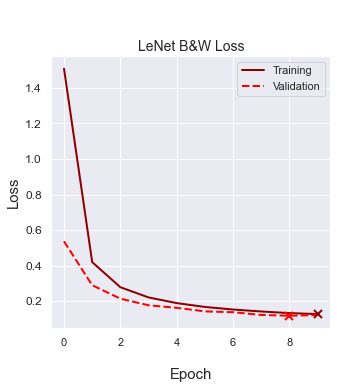

In [25]:
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)
# get max values for annotation
ind_xtl = np.argmin(model_LeNet_BW_fit.history['loss'])
ind_xvl = np.argmin(model_LeNet_BW_fit.history['val_loss'])
plt.title('\n\nLeNet B&W Loss',size=14)

ax1.set_xlabel('\nEpoch', size=15)
ax1.set_ylabel('Loss',size=15)
    
ax1.plot(model_LeNet_BW_fit.history['loss'], color='darkred', linestyle='-',linewidth=2,label='Training')
plt.plot(model_LeNet_BW_fit.history['val_loss'], color='red', linestyle='--',linewidth=2,label='Validation')

plt.plot(ind_xtl, model_LeNet_BW_fit.history['loss'][ind_xtl], 'rx', color='darkred', markersize=8, markeredgewidth=2)
plt.plot(ind_xvl, model_LeNet_BW_fit.history['val_loss'][ind_xvl], 'rx', color='red', markersize=8, markeredgewidth=2)

for tl in ax1.get_yticklabels():
    tl.set_fontsize(12)

plt.legend()

plt.show()